# ATLAS OmniFold

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Utilities

In [7]:
def standardize(data):
    orderOfMagnitude = int(math.log(np.mean(data), 10))

    return data / (10**orderOfMagnitude)

In [8]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Load ROOT file

In [9]:
zmumu_0 = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [10]:
zmumu_0.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [11]:
mybranches_0 = []
for mykey in zmumu_0.keys():
    mybranches_0 += [mykey.decode("utf-8")]

In [12]:
Events_0 = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches_0,
                               col_names=mybranches_0,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  78.87180423736572  seconds


In [13]:
zmumu_unknown = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Nov6_Sherpa2210_CVetoBVeto_mc16e_LooseTTVA.root"
)['EventTree']

In [14]:
zmumu_unknown.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [15]:
mybranches_unknown = []
for mykey in zmumu_unknown.keys():
    mybranches_unknown += [mykey.decode("utf-8")]

In [16]:
Events_unknown = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Nov6_Sherpa2210_CVetoBVeto_mc16e_LooseTTVA.root"
],
                               "EventTree",
                               branch_list=mybranches_unknown,
                               col_names=mybranches_unknown,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  977568
Events in returned Object:  977568
Loading the data took  65.75544619560242  seconds


### Unpack data

In [17]:
# weightsMC_0 = Events_0.events['weight']
# # standardize
# weightsMC_0 = weightsMC_0/np.mean(weightsMC_0)

# weightsMC_unknown = Events_unknown.events['weight']
# # standardize
# weightsMC_unknown = weightsMC_unknown/np.mean(weightsMC_unknown)

In [18]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass_0 = (Events_0.events['m_ll'] > 0) & (Events_0.events['m_ll'] < 200) & (
    Events_0.events['truth_m_ll'] > 0) & (Events_0.events['truth_m_ll'] < 200)

mypass_unknown = (Events_unknown.events['m_ll'] > 0) & (Events_unknown.events['m_ll'] < 200) & (
    Events_unknown.events['truth_m_ll'] > 0) & (Events_unknown.events['truth_m_ll'] < 200)

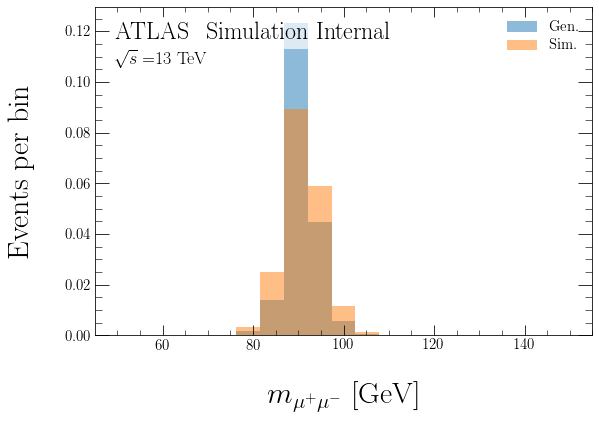

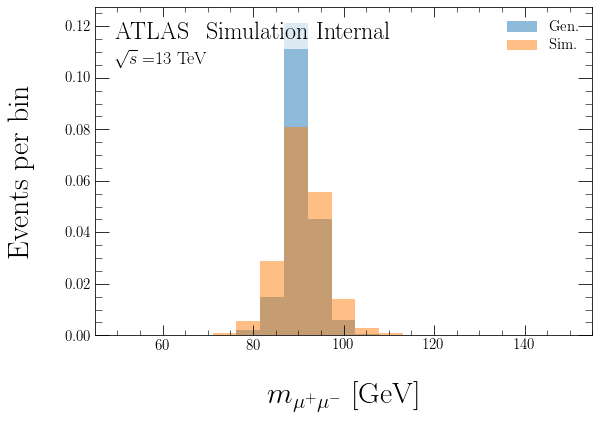

In [19]:
plt.figure()
hG, _, _ = plt.hist(Events_0.events['truth_m_ll'][mypass_0],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_0.events['m_ll'][mypass_0],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

plt.figure()
hG, _, _ = plt.hist(Events_unknown.events['truth_m_ll'][mypass_unknown],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_unknown[mypass_unknown],
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_unknown.events['m_ll'][mypass_unknown],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_unknown[mypass_unknown],
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

In [20]:
mytracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
ntrack_0_Gen = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [21]:
mytracks_0 = Events_0.events['pT_Tracks'][mypass_0]
ntrack_0_Sim = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [22]:
mytracks_unknown = Events_unknown.events['truth_pT_Tracks'][mypass_unknown]
ntrack_unknown_Gen = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

In [23]:
mytracks_unknown = Events_unknown.events['pT_Tracks'][mypass_unknown]
ntrack_unknown_Sim = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

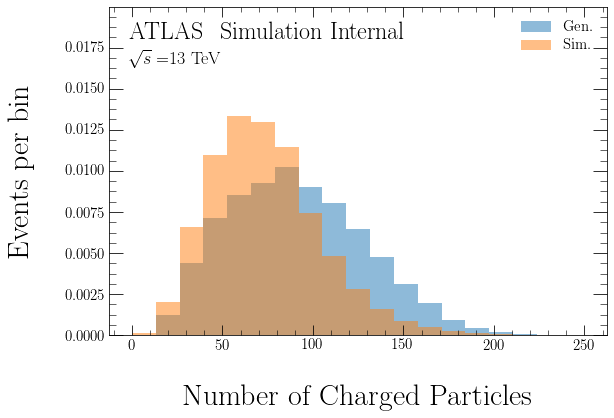

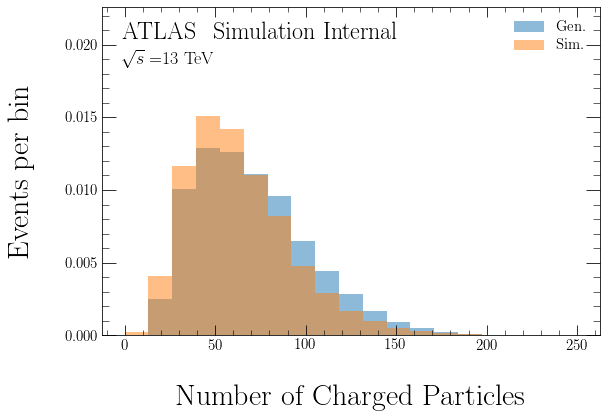

In [24]:
hG, _, _ = plt.hist(ntrack_0_Gen,
#                     weights=weightsMC_0[mypass_0],
                    label="Gen.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_0_Sim,
#                     weights=weightsMC_0[mypass_0],
                    label="Sim.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

hG, _, _ = plt.hist(ntrack_unknown_Gen,
#                     weights=weightsMC_unknown[mypass_unknown],
                    label="Gen.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_unknown_Sim,
#                     weights=weightsMC_unknown[mypass_unknown],
                    label="Sim.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup Datasets

In [25]:
m_ll_0_G = Events_0.events['truth_m_ll'][mypass_0]
m_ll_0_S = Events_0.events['m_ll'][mypass_0]

m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

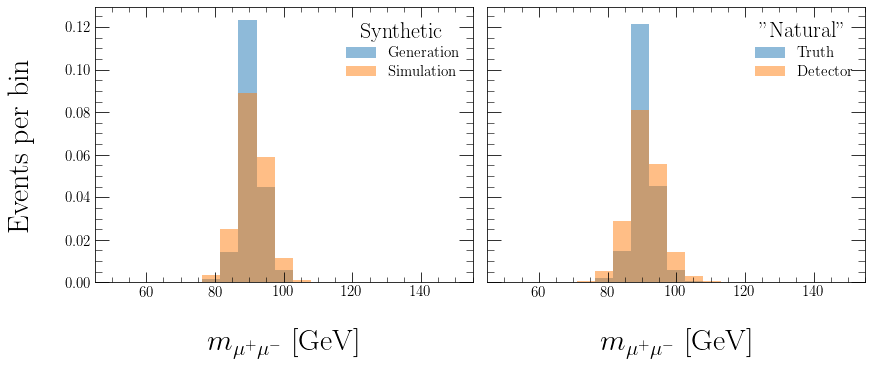

In [26]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, 
                       label='Generation', 
                       **plot_style_2)
hS0, _, _ = ax[0].hist(m_ll_0_S, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, label='Simulation', 
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G, 
#                        weights=weightsMC_unknown[mypass_unknown], 
                       bins=bins,
                       label='Truth', 
                       **plot_style_2)
hS1, _, _ = ax[1].hist(m_ll_unknown_S, 
#                        weights=weightsMC_unknown[mypass_unknown], 
                       bins=bins, 
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

In [27]:
nTracks_0_G = np.array(ntrack_0_Gen)
nTracks_0_S = np.array(ntrack_0_Sim)
nTracks_unknown_G = np.array(ntrack_unknown_Gen)
nTracks_unknown_S = np.array(ntrack_unknown_Sim)

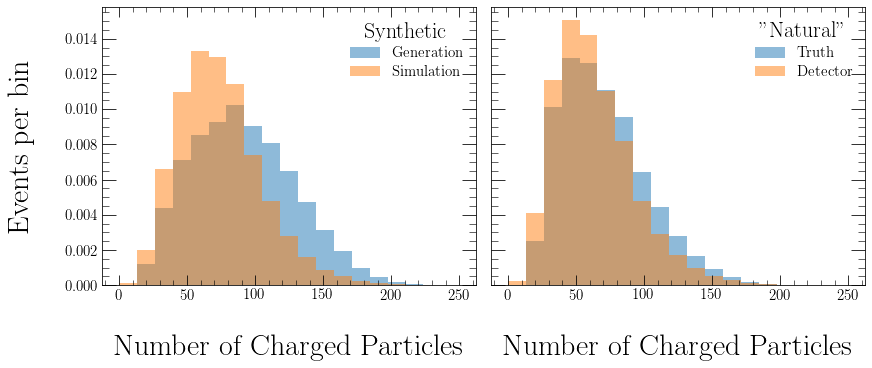

In [28]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Generation',
                       **plot_style_2)
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Simulation',
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       #weights=weightsMC_unknown[mypass_unknown],
                       bins=bins,
                       label='Truth',
                       **plot_style_2)
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       #weights=weightsMC_unknown[mypass_unknown],
                       bins=bins,
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define UniFold Algorithm

In [29]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level observable as Numpy array
                    
        theta_0_S: synthetic simulation-level observable as Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level observable 
                            to be unfolded as Numpy arrays
                            
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            theta_0_G,
            theta_0_S,
            theta_unknown_S,
            weightsMC_0=None,
            weightsMC_unknown=None):
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$

In [30]:
scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(m_ll_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(m_ll_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(m_ll_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(m_ll_unknown_S.reshape(-1,1)))

In [31]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=5,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=theta_unknown_S )#,
#                      weightsMC_unknown=weightsMC_unknown[mypass_unknown])





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1143892 samples, validate on 381298 samples
Epoch 1/200





1143892/1143892 [==============================] - 3s 3us/step - loss: 0.6727 - acc: 0.5915 - val_loss: 0.6710 - val_acc: 0.5938
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6715 - acc: 0.5915 - val_loss: 0.6709 - val_acc: 0.5938
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6714 - acc: 0.5915 - val_loss: 0.6709 - val_acc: 0.5938
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6714 - acc: 0.5915 - val_loss: 0.6709 - val_acc: 0.5938
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6714 - acc: 0.5915 - val_loss: 0.6710 - val_acc: 0.5938
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6714 - acc: 0.5915 - val_lo

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6712 - acc: 0.5915 - val_loss: 0.6707 - val_acc: 0.5938
Epoch 36/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6712 - acc: 0.5915 - val_loss: 0.6707 - val_acc: 0.5938
Epoch 37/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6712 - acc: 0.5915 - val_loss: 0.6708 - val_acc: 0.5938
Epoch 38/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6712 - acc: 0.5915 - val_loss: 0.6707 - val_acc: 0.5938
Epoch 39/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6712 - acc: 0.5915 - val_loss: 0.6707 - val_acc: 0.5938
Epoch 40/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6712 - acc: 0.5915 - val_loss: 0.6707 - val_acc: 0.5938
Restoring model weights from the end of the best epoch
Epoch 00040: early stopping

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoch 1/200
93316

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8161 - acc: 0.5058 - val_loss: 0.8163 - val_acc: 0.5010
Epoch 34/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8161 - acc: 0.5064 - val_loss: 0.8162 - val_acc: 0.5002
Epoch 35/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8161 - acc: 0.5054 - val_loss: 0.8162 - val_acc: 0.5014
Epoch 36/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8161 - acc: 0.5053 - val_loss: 0.8163 - val_acc: 0.5010
Epoch 37/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8161 - acc: 0.5063 - val_loss: 0.8163 - val_acc: 0.5005
Epoch 38/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8161 - acc: 0.5060 - val_loss: 0.8163 - val_acc: 0.5004
Epoch 39/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8161 - acc: 0.5048 - val_loss: 0.8163 - val_acc: 0.5085
Epoch 40/200
114389

933165/933165 [==============================] - 5s 6us/step - loss: 0.8230 - acc: 0.5002 - val_loss: 0.8209 - val_acc: 0.5000
Epoch 2/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8206 - acc: 0.5000 - val_loss: 0.8208 - val_acc: 0.5000
Epoch 3/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8206 - acc: 0.5000 - val_loss: 0.8208 - val_acc: 0.5000
Epoch 4/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8206 - acc: 0.5000 - val_loss: 0.8208 - val_acc: 0.5000
Epoch 5/200
933165/933165 [==============================] - 3s 3us/step - loss: 0.8206 - acc: 0.5000 - val_loss: 0.8209 - val_acc: 0.5000
Epoch 6/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8206 - acc: 0.5000 - val_loss: 0.8208 - val_acc: 0.5000
Epoch 7/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8205 - acc: 0.5000 - val_loss: 0.8209 - val_acc: 0.5000
Epoch 8/200
933165/933165 [============

1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8218 - acc: 0.4713 - val_loss: 0.8219 - val_acc: 0.4840
Epoch 8/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8218 - acc: 0.4750 - val_loss: 0.8219 - val_acc: 0.4528
Epoch 9/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8218 - acc: 0.4726 - val_loss: 0.8219 - val_acc: 0.4629
Epoch 10/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8218 - acc: 0.4733 - val_loss: 0.8219 - val_acc: 0.4868
Epoch 11/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8218 - acc: 0.4720 - val_loss: 0.8219 - val_acc: 0.4879
Epoch 12/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8218 - acc: 0.4763 - val_loss: 0.8219 - val_acc: 0.4601
Epoch 13/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8218 - acc: 0.4758 - val_loss: 0.8219 - val_acc: 0.4540
Epoch 14/200
1143892/

#### Step 1 Results (Simulation-level)

ITERATION 1:


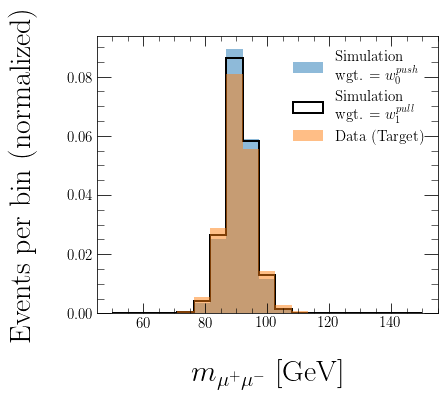

ITERATION 2:


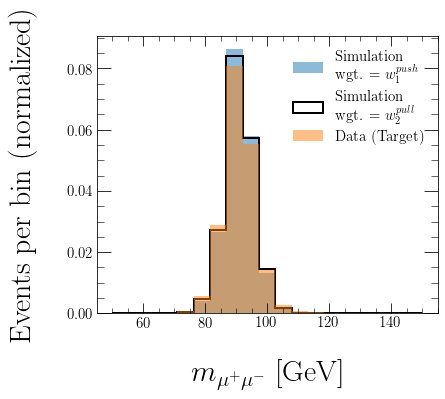

ITERATION 3:


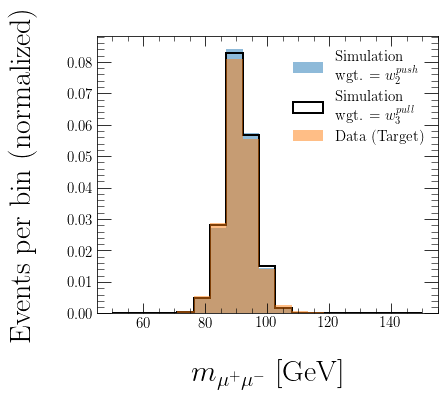

ITERATION 4:


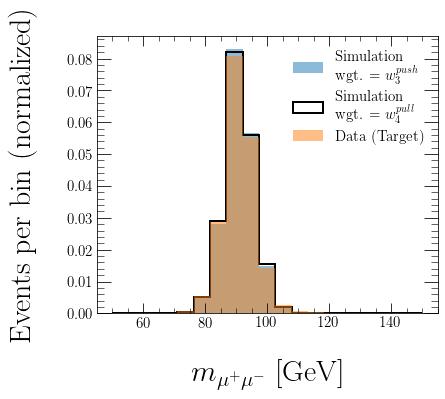

ITERATION 5:


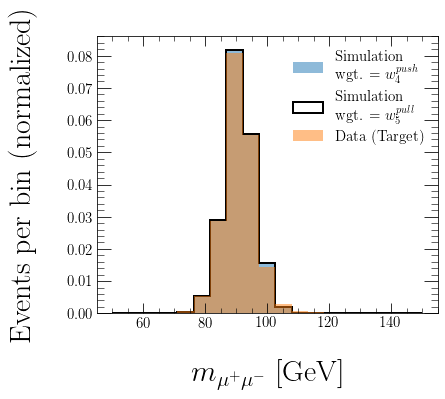

In [32]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(m_ll_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        m_ll_0_S,
        weights=weights_init,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2)

    hist1 = plt.hist(
        m_ll_0_S,
        weights=weights[i, 1, :],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    hist2 = plt.hist(
        m_ll_unknown_S,
        #                      weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


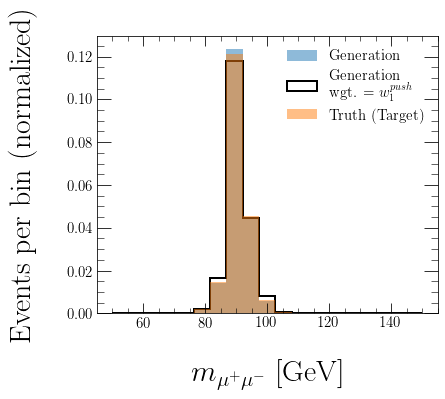

ITERATION 2:


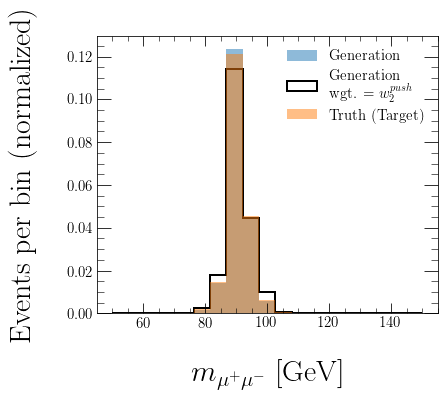

ITERATION 3:


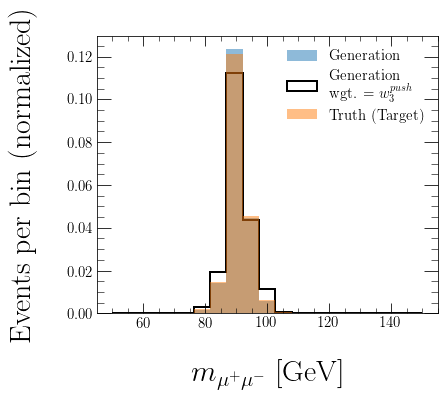

ITERATION 4:


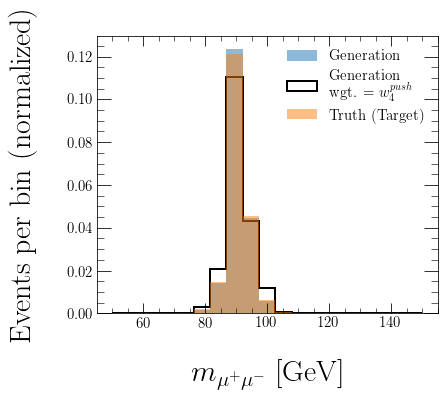

ITERATION 5:


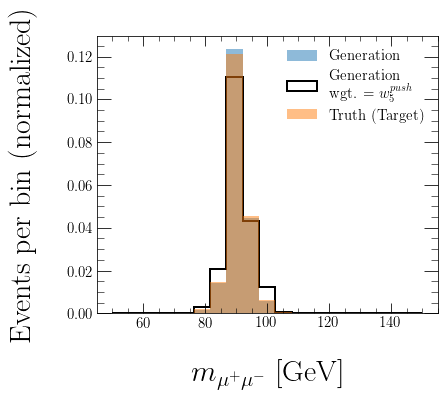

In [33]:
for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        m_ll_0_G,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)

    hist1 = plt.hist(m_ll_0_G,
                     weights=weights[i, 1, :],
                     bins=bins,
                     label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) + '}'),
                     **plot_style_1)
    hist2 = plt.hist(
        m_ll_unknown_G,
        #                      weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold Number of Charged Particles

In [34]:
scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(nTracks_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(nTracks_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(nTracks_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(nTracks_unknown_S.reshape(-1,1)))

In [35]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=theta_unknown_S)#,
#                      weightsMC_unknown=weightsMC_unknown[mypass_unknown])


ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 6s 5us/step - loss: 0.6618 - acc: 0.6013 - val_loss: 0.6598 - val_acc: 0.6011
Epoch 2/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.6593 - acc: 0.6024 - val_loss: 0.6597 - val_acc: 0.6014
Epoch 3/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.6593 - acc: 0.6022 - val_loss: 0.6597 - val_acc: 0.6016
Epoch 4/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.6593 - acc: 0.6021 - val_loss: 0.6597 - val_acc: 0.6014
Epoch 5/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.6592 - acc: 0.6021 - val_loss: 0.6597 - val_acc: 0.6014
Epoch 6/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.6592 - acc: 0.6023 - val_loss: 0.6597 - val_acc: 0.6016
Epoch 7/200
1143892/1143892 [==============================] - 4s 4us/step - l

933165/933165 [==============================] - 3s 4us/step - loss: 0.8189 - acc: 0.5004 - val_loss: 0.8185 - val_acc: 0.4986
Epoch 7/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8189 - acc: 0.5006 - val_loss: 0.8185 - val_acc: 0.4986
Epoch 8/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8189 - acc: 0.5004 - val_loss: 0.8185 - val_acc: 0.4987
Epoch 9/200
933165/933165 [==============================] - 3s 3us/step - loss: 0.8189 - acc: 0.5005 - val_loss: 0.8185 - val_acc: 0.4985
Epoch 10/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8189 - acc: 0.5005 - val_loss: 0.8186 - val_acc: 0.4987
Epoch 11/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8189 - acc: 0.5005 - val_loss: 0.8185 - val_acc: 0.4986
Epoch 12/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8189 - acc: 0.5005 - val_loss: 0.8184 - val_acc: 0.4988
Epoch 13/200
933165/933165 [========

1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8179 - acc: 0.5728 - val_loss: 0.8173 - val_acc: 0.5671
Epoch 5/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8179 - acc: 0.5707 - val_loss: 0.8174 - val_acc: 0.5672
Epoch 6/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8179 - acc: 0.5716 - val_loss: 0.8173 - val_acc: 0.5705
Epoch 7/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8179 - acc: 0.5697 - val_loss: 0.8173 - val_acc: 0.5726
Epoch 8/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8179 - acc: 0.5702 - val_loss: 0.8174 - val_acc: 0.5747
Epoch 9/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8179 - acc: 0.5693 - val_loss: 0.8173 - val_acc: 0.5734
Epoch 10/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8179 - acc: 0.5684 - val_loss: 0.8174 - val_acc: 0.5673
Epoch 11/200
1143892/114

933165/933165 [==============================] - 3s 4us/step - loss: 0.7930 - acc: 0.5002 - val_loss: 0.7937 - val_acc: 0.4992
Epoch 5/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.7931 - acc: 0.5001 - val_loss: 0.7938 - val_acc: 0.4992
Epoch 6/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.7930 - acc: 0.5002 - val_loss: 0.7937 - val_acc: 0.4992
Epoch 7/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.7930 - acc: 0.5002 - val_loss: 0.7939 - val_acc: 0.4994
Epoch 8/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.7931 - acc: 0.5002 - val_loss: 0.7937 - val_acc: 0.4994
Epoch 9/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.7930 - acc: 0.5002 - val_loss: 0.7938 - val_acc: 0.4994
Epoch 10/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.7931 - acc: 0.5003 - val_loss: 0.7937 - val_acc: 0.4994
Epoch 11/200
933165/933165 [==========

933165/933165 [==============================] - 2s 2us/step - loss: 0.7919 - acc: 0.4996 - val_loss: 0.7917 - val_acc: 0.5009
Epoch 6/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7919 - acc: 0.4997 - val_loss: 0.7917 - val_acc: 0.5009
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7919 - acc: 0.4997 - val_loss: 0.7917 - val_acc: 0.5009
Epoch 8/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7920 - acc: 0.4997 - val_loss: 0.7917 - val_acc: 0.5009
Epoch 9/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7919 - acc: 0.4998 - val_loss: 0.7917 - val_acc: 0.5009
Epoch 10/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7919 - acc: 0.4997 - val_loss: 0.7918 - val_acc: 0.5009
Epoch 11/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7920 - acc: 0.4997 - val_loss: 0.7918 - val_acc: 0.5009
Epoch 12/200
933165/933165 [=========

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8170 - acc: 0.5667 - val_loss: 0.8171 - val_acc: 0.5761
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8170 - acc: 0.5745 - val_loss: 0.8170 - val_acc: 0.5851
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8170 - acc: 0.5744 - val_loss: 0.8170 - val_acc: 0.5811
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8170 - acc: 0.5778 - val_loss: 0.8170 - val_acc: 0.5850
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8170 - acc: 0.5768 - val_loss: 0.8170 - val_acc: 0.5635
Epoch 7/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8170 - acc: 0.5761 - val_loss: 0.8170 - val_acc: 0.5641
Epoch 8/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8170 - acc: 0.5767 - val_loss: 0.8170 - val_acc: 0.5727
Epoch 9/200
1143892/11438

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8190 - acc: 0.5674 - val_loss: 0.8192 - val_acc: 0.5717
Epoch 9/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8190 - acc: 0.5675 - val_loss: 0.8192 - val_acc: 0.5711
Epoch 10/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8190 - acc: 0.5626 - val_loss: 0.8192 - val_acc: 0.5747
Epoch 11/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8190 - acc: 0.5691 - val_loss: 0.8192 - val_acc: 0.5345
Epoch 12/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8190 - acc: 0.5710 - val_loss: 0.8192 - val_acc: 0.5765
Epoch 13/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8190 - acc: 0.5691 - val_loss: 0.8192 - val_acc: 0.5529
Epoch 14/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8190 - acc: 0.5531 - val_loss: 0.8193 - val_acc: 0.5893
Epoch 15/200
1143892

933165/933165 [==============================] - 2s 2us/step - loss: 0.7898 - acc: 0.5001 - val_loss: 0.7900 - val_acc: 0.4995
Epoch 6/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7898 - acc: 0.5002 - val_loss: 0.7900 - val_acc: 0.4995
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7898 - acc: 0.5002 - val_loss: 0.7900 - val_acc: 0.4995
Epoch 8/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7898 - acc: 0.5002 - val_loss: 0.7900 - val_acc: 0.4995
Epoch 9/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7898 - acc: 0.5002 - val_loss: 0.7900 - val_acc: 0.4995
Epoch 10/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7898 - acc: 0.5001 - val_loss: 0.7900 - val_acc: 0.4997
Epoch 11/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7898 - acc: 0.5002 - val_loss: 0.7901 - val_acc: 0.4995
Restoring model weights from the end 

#### Step 1 Results (Simulation-level)

ITERATION 1:


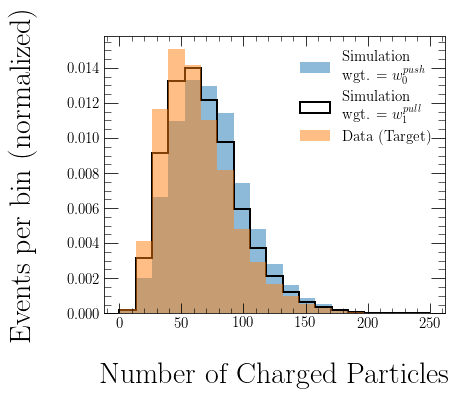

ITERATION 2:


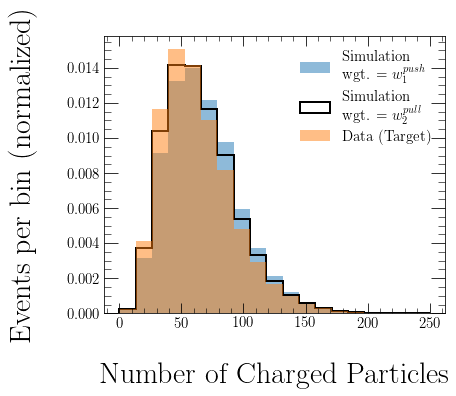

ITERATION 3:


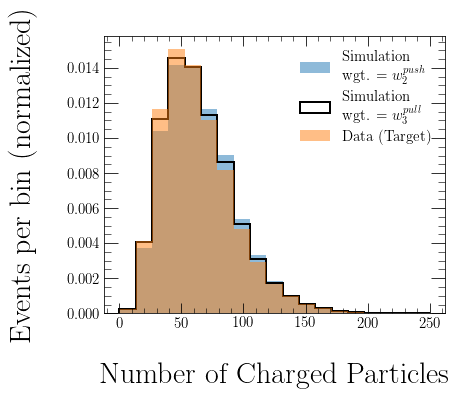

ITERATION 4:


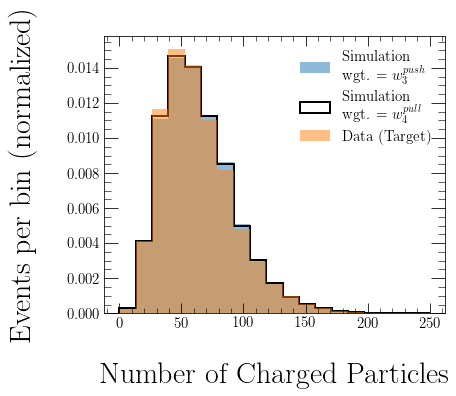

ITERATION 5:


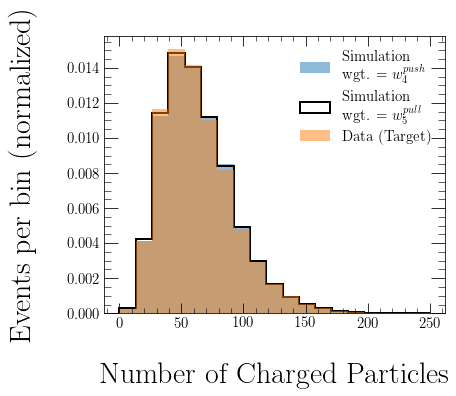

ITERATION 6:


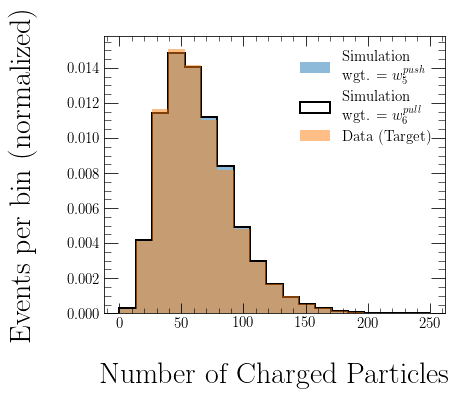

ITERATION 7:


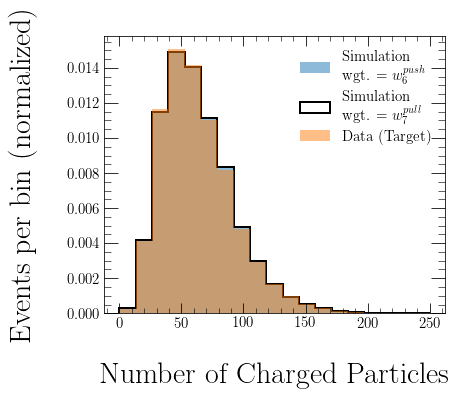

ITERATION 8:


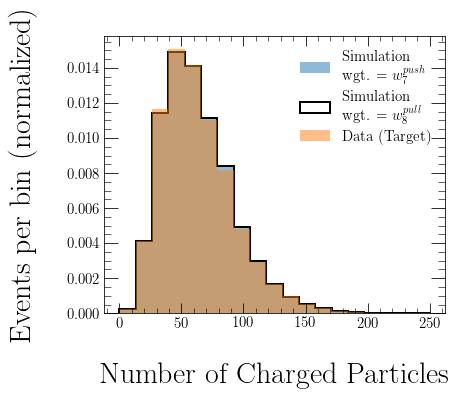

ITERATION 9:


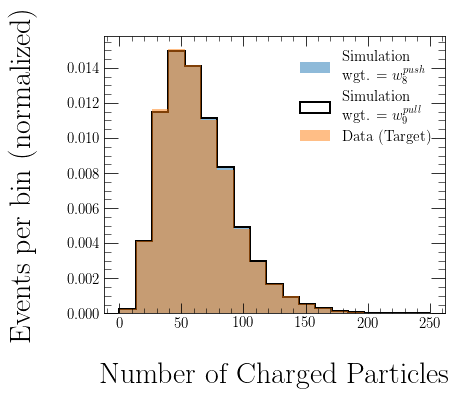

ITERATION 10:


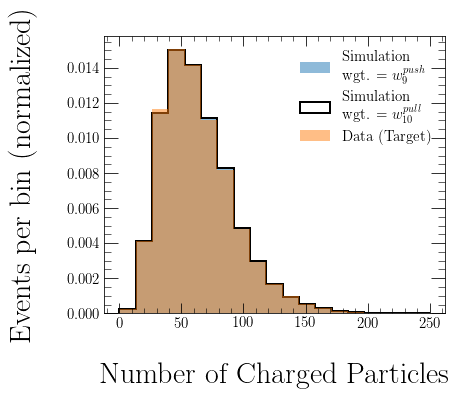

In [36]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(nTracks_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        nTracks_0_S,
        weights=weights_init,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2)

    hist1 = plt.hist(
        nTracks_0_S,
        weights=weights[i, 1, :],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    hist2 = plt.hist(
        nTracks_unknown_S,
        #                      weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


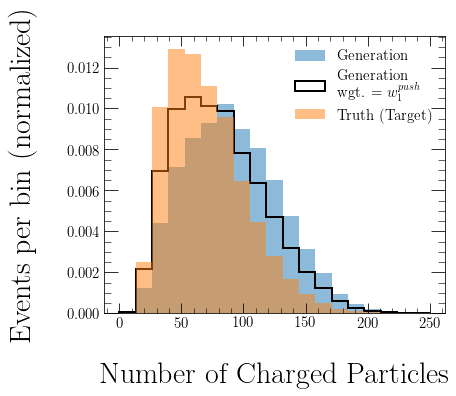

ITERATION 2:


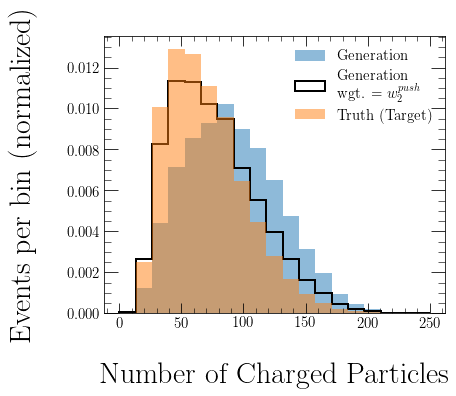

ITERATION 3:


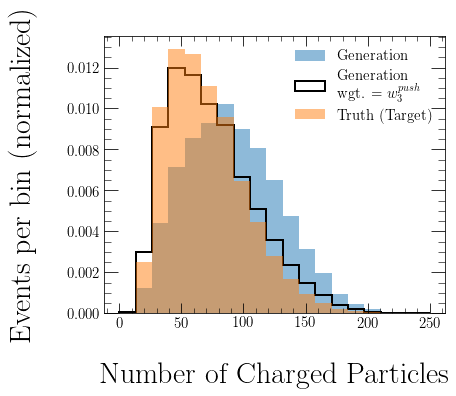

ITERATION 4:


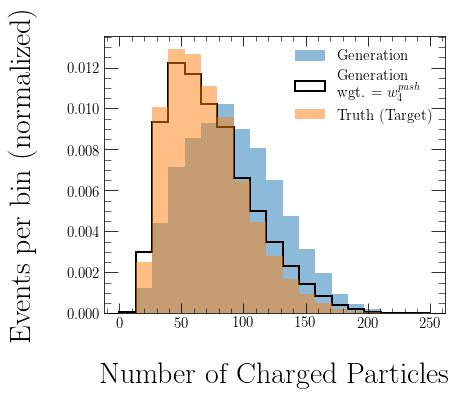

ITERATION 5:


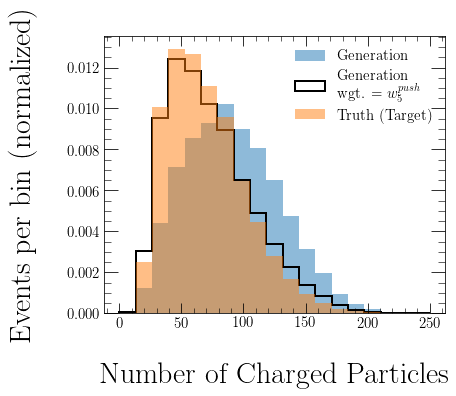

ITERATION 6:


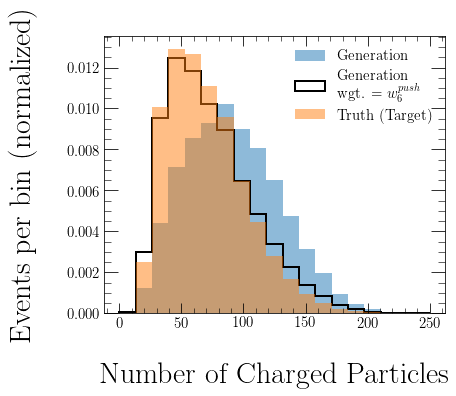

ITERATION 7:


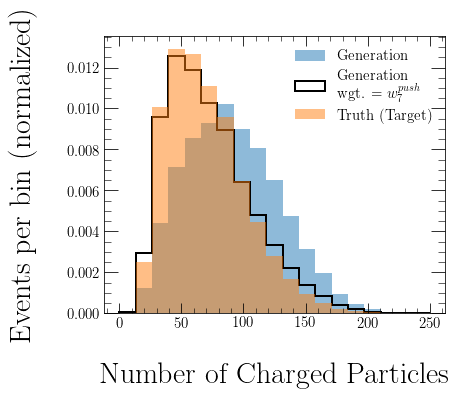

ITERATION 8:


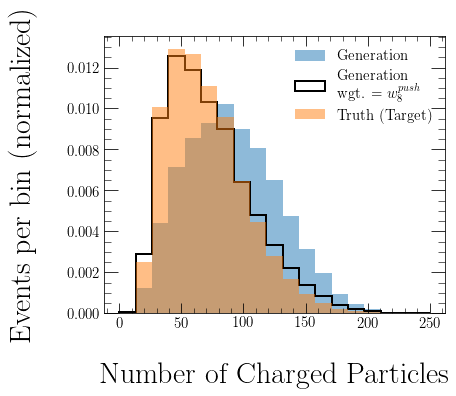

ITERATION 9:


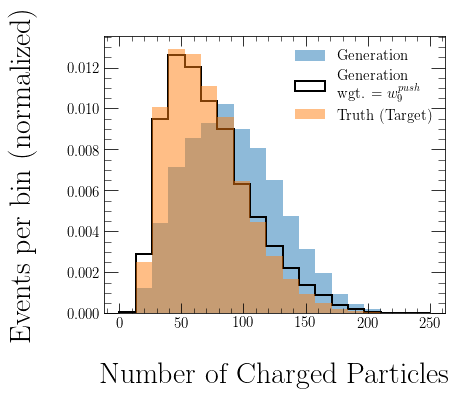

ITERATION 10:


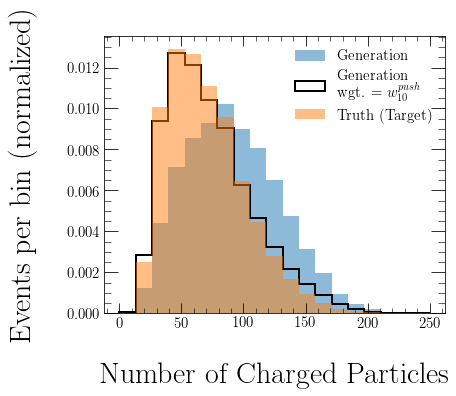

In [37]:
for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        nTracks_0_G,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)

    hist1 = plt.hist(nTracks_0_G,
                     weights=weights[i, 1, :],
                     bins=bins,
                     label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) + '}'),
                     **plot_style_1)
    hist2 = plt.hist(
        nTracks_unknown_G,
        #                      weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [38]:
K.clear_session()

### Setup datasets

In [39]:
m_ll_0_G = Events_0.events['truth_m_ll'][mypass_0]
m_ll_0_S = Events_0.events['m_ll'][mypass_0]

m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

nTracks_0_G = np.array(ntrack_0_Gen)
nTracks_0_S = np.array(ntrack_0_Sim)

nTracks_unknown_G = np.array(ntrack_unknown_Gen)
nTracks_unknown_S = np.array(ntrack_unknown_Sim)

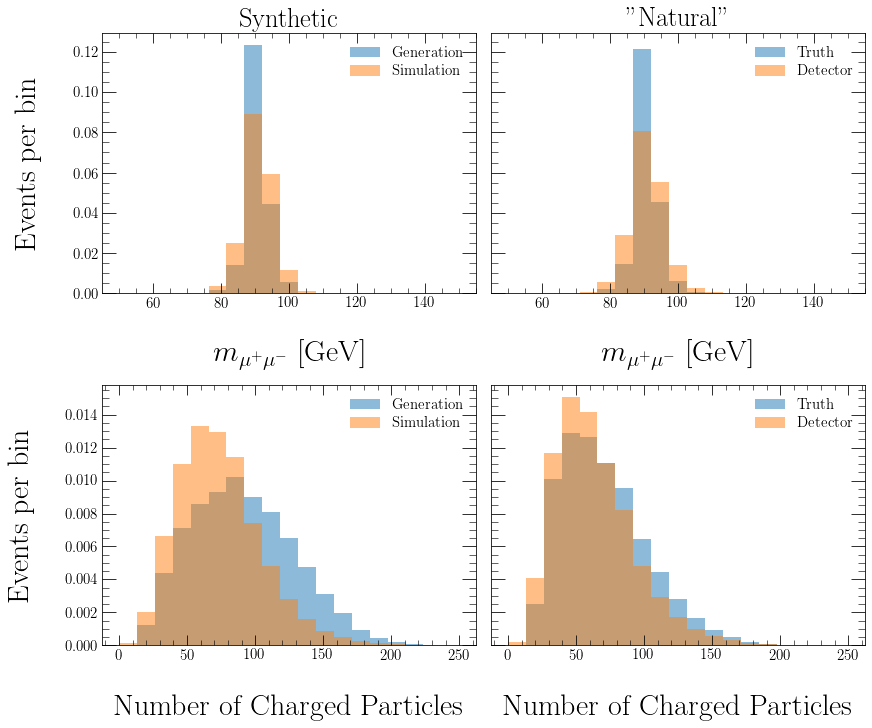

In [40]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[0, 0].hist(m_ll_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define MultiFold Algorithm

In [41]:
# Input multiple observables as tuple or list (i.e. theta_0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta_0_G: tuple or list of synthetic 
                    generation-level observables as Numpy arrays
                    
        theta_0_S: tuple or list of synthetic 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def multifold(num_observables,
              iterations,
              theta_0_G,
              theta_0_S,
              theta_unknown_S,
              weightsMC_0=None,
              weightsMC_unknown=None):

    theta_0_G = np.stack(theta_0_G, axis=1)
    theta_0_S = np.stack(theta_0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta_0_S))
    weights_push = np.ones(len(theta_0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta_0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [42]:
num_observables = 2

scaler_m_ll_G = preprocessing.StandardScaler()
scaler_m_ll_S = preprocessing.StandardScaler()

scaler_m_ll_G.fit(m_ll_0_G.reshape(-1,1))
scaler_m_ll_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

scaler_nTracks_G = preprocessing.StandardScaler()
scaler_nTracks_S = preprocessing.StandardScaler()

scaler_nTracks_G.fit(nTracks_0_G.reshape(-1,1))
scaler_nTracks_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = (np.squeeze(scaler_m_ll_G.transform(m_ll_0_G.reshape(-1,1))),
             np.squeeze(scaler_nTracks_G.transform(nTracks_0_G.reshape(-1,1))))

theta_0_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_0_S.reshape(-1,1))),
             np.squeeze(scaler_nTracks_S.transform(nTracks_0_S.reshape(-1,1))))

theta_unknown_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_unknown_S.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_S.transform(nTracks_unknown_S.reshape(-1,1))))

In [43]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       theta_0_G=theta_0_G,
                       theta_0_S=theta_0_S,
#                        weightsMC_0=weightsMC_0[mypass_0],
                       theta_unknown_S=theta_unknown_S)#,
#                        weightsMC_unknown=weightsMC_unknown[mypass_unknown])


ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 3s 3us/step - loss: 0.6571 - acc: 0.6042 - val_loss: 0.6544 - val_acc: 0.6085
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6545 - acc: 0.6083 - val_loss: 0.6541 - val_acc: 0.6091
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6543 - acc: 0.6086 - val_loss: 0.6540 - val_acc: 0.6092
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6543 - acc: 0.6086 - val_loss: 0.6543 - val_acc: 0.6094
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6543 - acc: 0.6086 - val_loss: 0.6540 - val_acc: 0.6094
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6543 - acc: 0.6087 - val_loss: 0.6540 - val_acc: 0.6092
Epoch 7/200
1143892/1143892 [==============================] - 2s 2us/step - l

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8169 - acc: 0.5725 - val_loss: 0.8177 - val_acc: 0.5709
Epoch 8/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8169 - acc: 0.5722 - val_loss: 0.8177 - val_acc: 0.5649
Epoch 9/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8169 - acc: 0.5718 - val_loss: 0.8177 - val_acc: 0.5662
Epoch 10/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8169 - acc: 0.5721 - val_loss: 0.8178 - val_acc: 0.5702
Epoch 11/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8169 - acc: 0.5719 - val_loss: 0.8177 - val_acc: 0.5780
Epoch 12/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8169 - acc: 0.5725 - val_loss: 0.8177 - val_acc: 0.5697
Epoch 13/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8169 - acc: 0.5708 - val_loss: 0.8177 - val_acc: 0.5754
Epoch 14/200
1143892/

Epoch 10/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8220 - acc: 0.5523 - val_loss: 0.8212 - val_acc: 0.5370
Epoch 11/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8220 - acc: 0.5500 - val_loss: 0.8212 - val_acc: 0.5393
Epoch 12/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8220 - acc: 0.5496 - val_loss: 0.8212 - val_acc: 0.5662
Epoch 13/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8220 - acc: 0.5506 - val_loss: 0.8212 - val_acc: 0.5557
Epoch 14/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8220 - acc: 0.5500 - val_loss: 0.8213 - val_acc: 0.5276
Epoch 15/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8220 - acc: 0.5502 - val_loss: 0.8213 - val_acc: 0.5403
Epoch 16/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8220 - acc: 0.5488 - val_loss: 0.8212 - val_acc: 0.5403
Epoch 

933165/933165 [==============================] - 3s 4us/step - loss: 0.7931 - acc: 0.5003 - val_loss: 0.7850 - val_acc: 0.4998
Epoch 2/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7856 - acc: 0.5000 - val_loss: 0.7851 - val_acc: 0.4998
Epoch 3/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7856 - acc: 0.5000 - val_loss: 0.7849 - val_acc: 0.4997
Epoch 4/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7856 - acc: 0.5000 - val_loss: 0.7850 - val_acc: 0.4998
Epoch 5/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7856 - acc: 0.5000 - val_loss: 0.7850 - val_acc: 0.4998
Epoch 6/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7856 - acc: 0.5000 - val_loss: 0.7850 - val_acc: 0.4999
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7855 - acc: 0.5002 - val_loss: 0.7849 - val_acc: 0.4998
Epoch 8/200
933165/933165 [============

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8238 - acc: 0.4866 - val_loss: 0.8237 - val_acc: 0.4931
Epoch 21/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8238 - acc: 0.4890 - val_loss: 0.8237 - val_acc: 0.4847
Epoch 22/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8238 - acc: 0.4907 - val_loss: 0.8237 - val_acc: 0.4756
Epoch 23/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8238 - acc: 0.4871 - val_loss: 0.8237 - val_acc: 0.4829
Epoch 24/200
1143892/1143892 [==============================] - 5s 4us/step - loss: 0.8238 - acc: 0.4897 - val_loss: 0.8238 - val_acc: 0.4555
Epoch 25/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8238 - acc: 0.4881 - val_loss: 0.8238 - val_acc: 0.4798
Epoch 26/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8238 - acc: 0.4883 - val_loss: 0.8237 - val_acc: 0.5108
Epoch 27/200
114389

1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8198 - acc: 0.5427 - val_loss: 0.8147 - val_acc: 0.5063
Epoch 2/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8160 - acc: 0.5208 - val_loss: 0.8146 - val_acc: 0.5330
Epoch 3/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8160 - acc: 0.5219 - val_loss: 0.8146 - val_acc: 0.5193
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8160 - acc: 0.5221 - val_loss: 0.8146 - val_acc: 0.5209
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8160 - acc: 0.5243 - val_loss: 0.8148 - val_acc: 0.5275
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8160 - acc: 0.5237 - val_loss: 0.8146 - val_acc: 0.5194
Epoch 7/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8160 - acc: 0.5242 - val_loss: 0.8147 - val_acc: 0.5309
Epoch 8/200
1143892/11438

1143892/1143892 [==============================] - 3s 3us/step - loss: 0.8176 - acc: 0.5054 - val_loss: 0.8172 - val_acc: 0.5155
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8176 - acc: 0.5065 - val_loss: 0.8172 - val_acc: 0.5094
Epoch 7/200
1143892/1143892 [==============================] - 6s 5us/step - loss: 0.8177 - acc: 0.5075 - val_loss: 0.8171 - val_acc: 0.4832
Epoch 8/200
1143892/1143892 [==============================] - 8s 7us/step - loss: 0.8176 - acc: 0.5059 - val_loss: 0.8171 - val_acc: 0.5034
Epoch 9/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8176 - acc: 0.5030 - val_loss: 0.8171 - val_acc: 0.5364
Epoch 10/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8176 - acc: 0.5080 - val_loss: 0.8171 - val_acc: 0.4929
Epoch 11/200
1143892/1143892 [==============================] - 3s 3us/step - loss: 0.8176 - acc: 0.5075 - val_loss: 0.8171 - val_acc: 0.5108
Epoch 12/200
1143892/11

#### Step 1 Results (Simulation-level)

ITERATION: 1


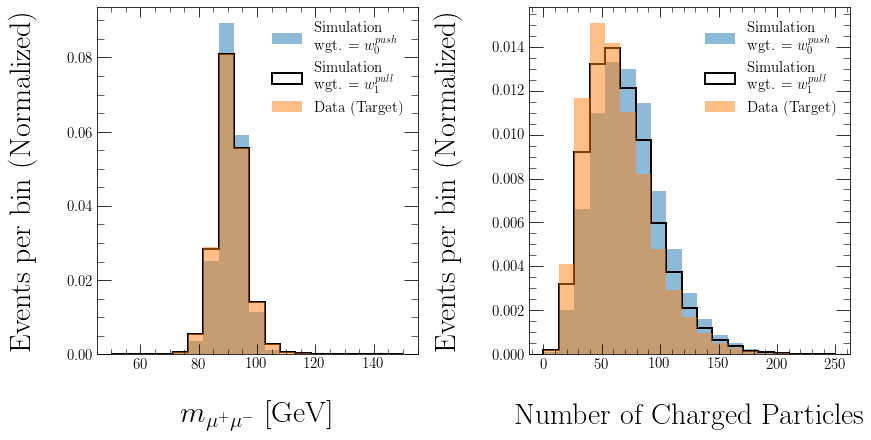

ITERATION: 2


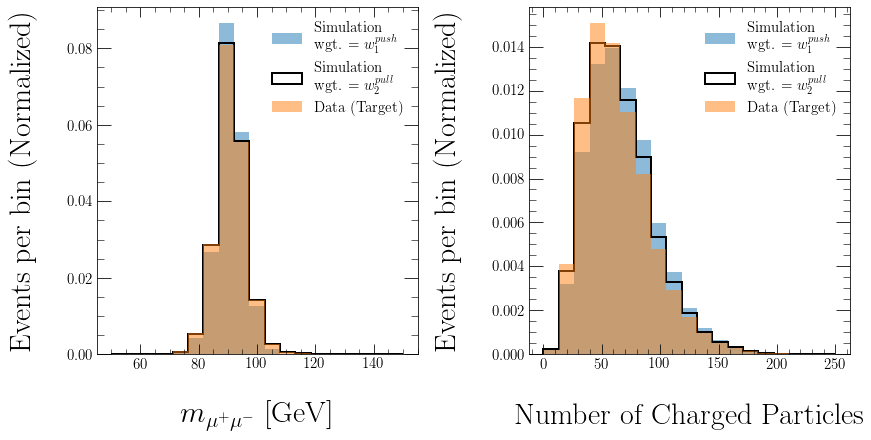

ITERATION: 3


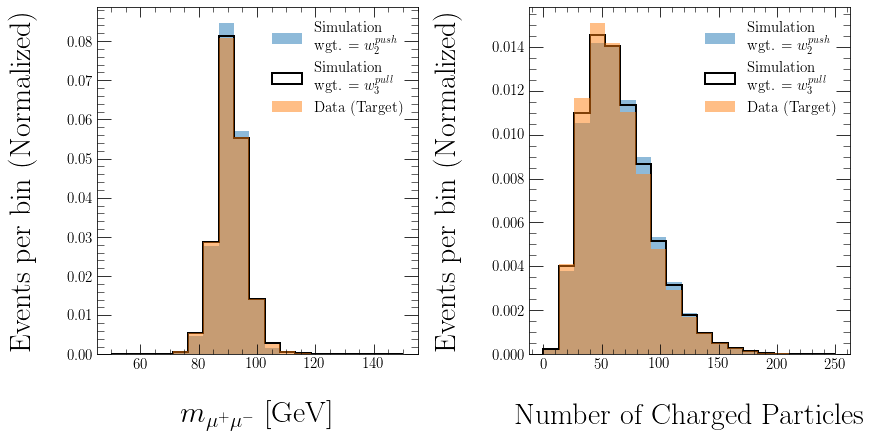

ITERATION: 4


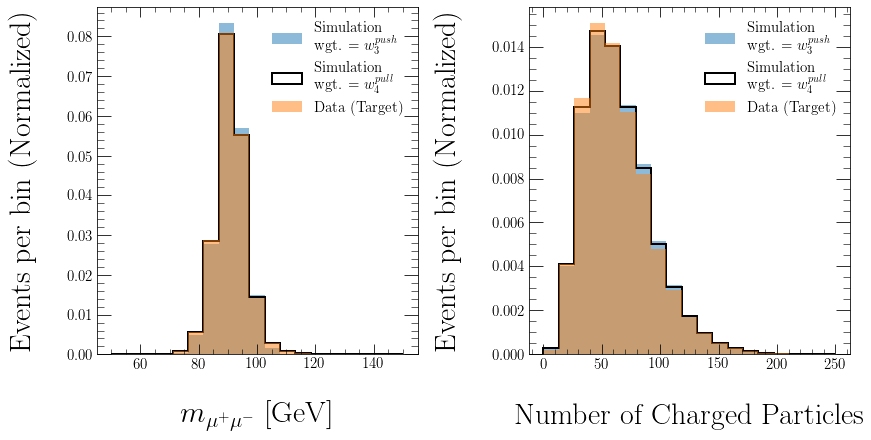

ITERATION: 5


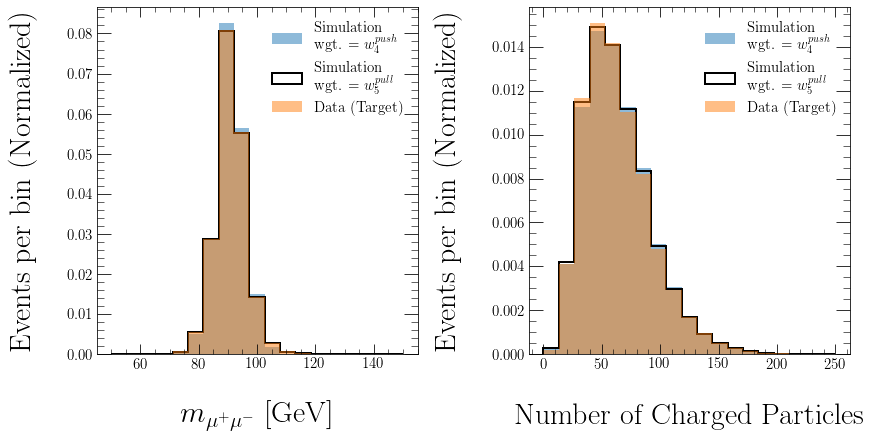

ITERATION: 6


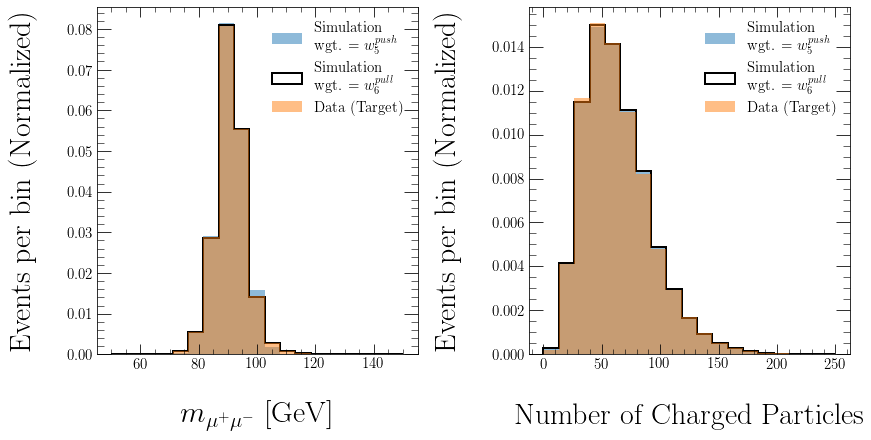

ITERATION: 7


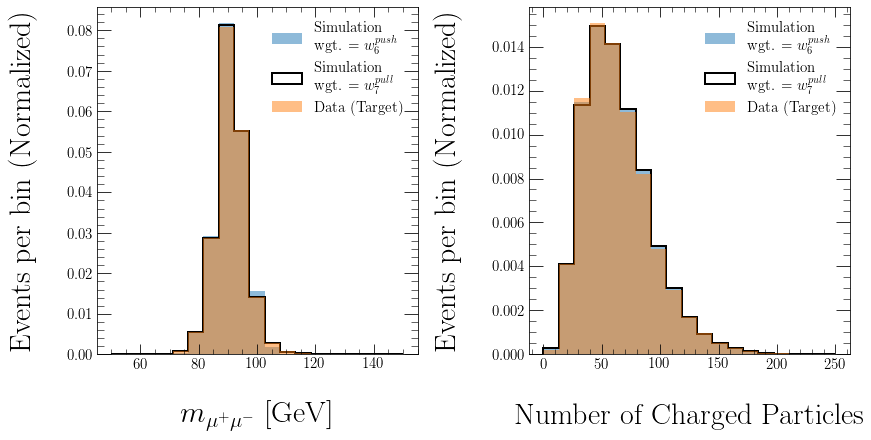

ITERATION: 8


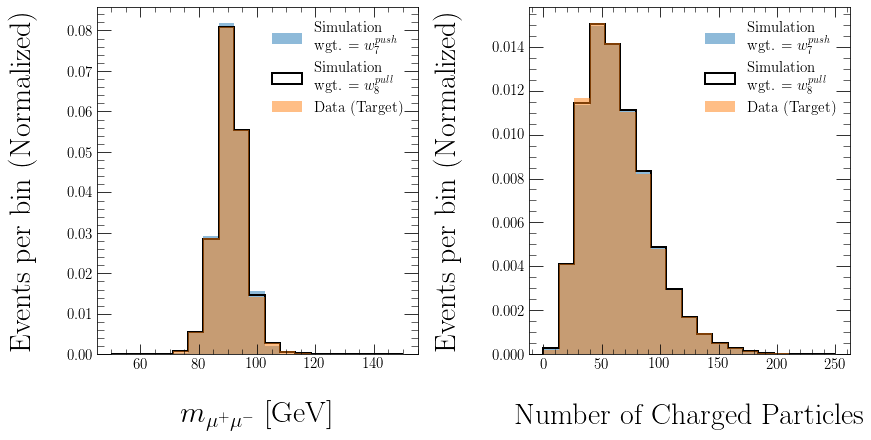

ITERATION: 9


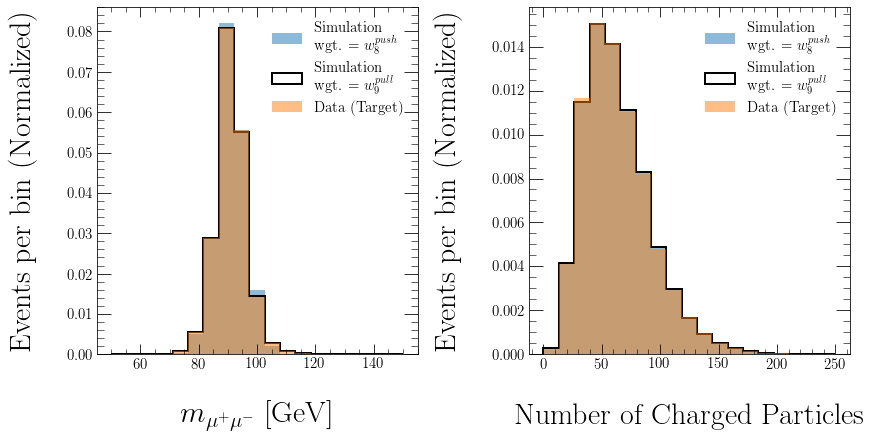

ITERATION: 10


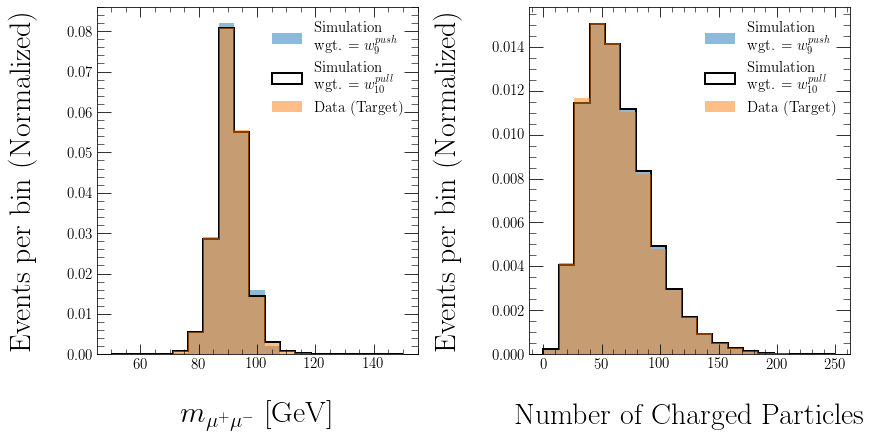

In [44]:
for i in range(len(weights)):

    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
    else:
        weights_init = weights[i - 1, 1, :]
        
    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(m_ll_0_S,
               weights=weights_init,
               bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
               **plot_style_2)
    ax[0].hist(m_ll_0_S,
               bins=bins,
               weights=weights[i, 0, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
               **plot_style_1)

    ax[0].hist(
        m_ll_unknown_S,
        #                weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_S,
               weights=weights_init,
               bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
               **plot_style_2)
    ax[1].hist(nTracks_0_S,
               bins=bins,
               weights=weights[i, 1, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
               **plot_style_1)
    ax[1].hist(
        nTracks_unknown_S,
        #                weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION: 1


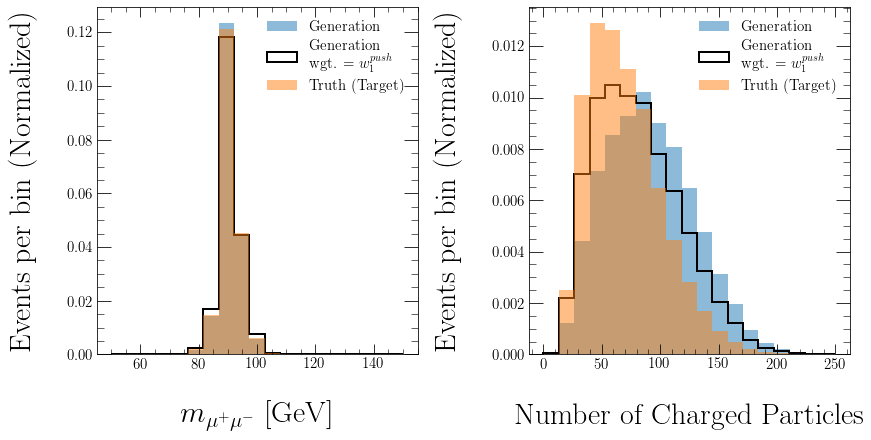

ITERATION: 2


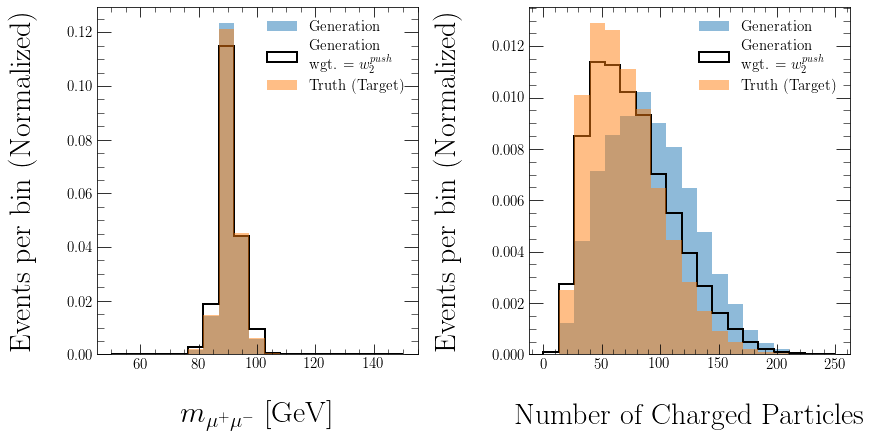

ITERATION: 3


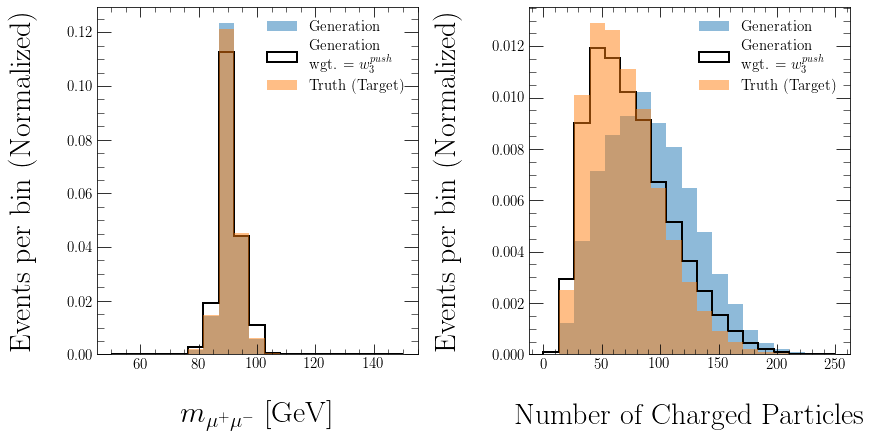

ITERATION: 4


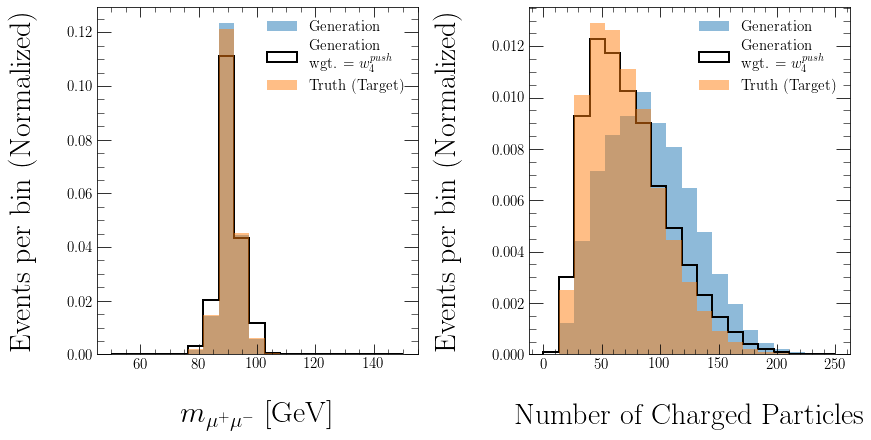

ITERATION: 5


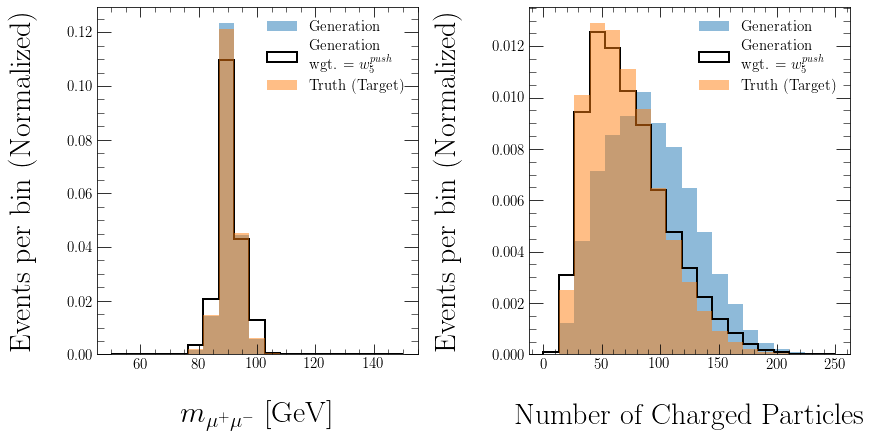

ITERATION: 6


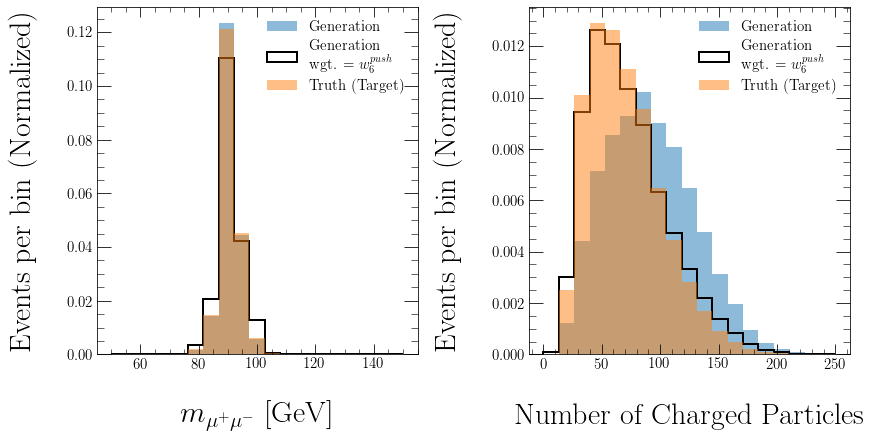

ITERATION: 7


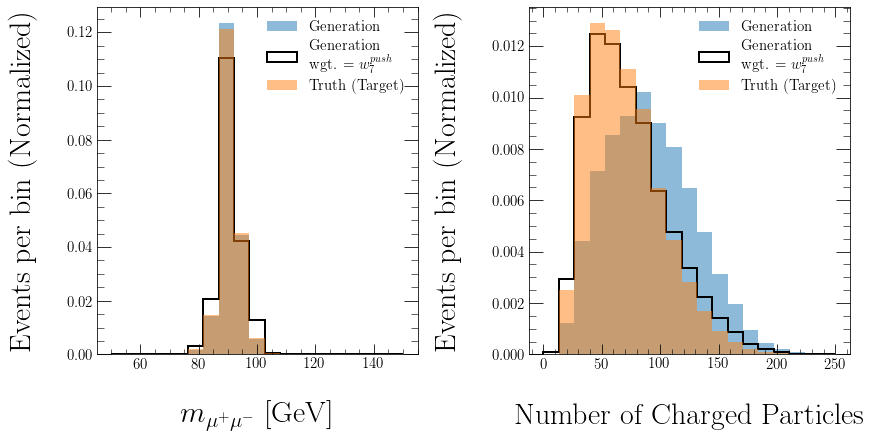

ITERATION: 8


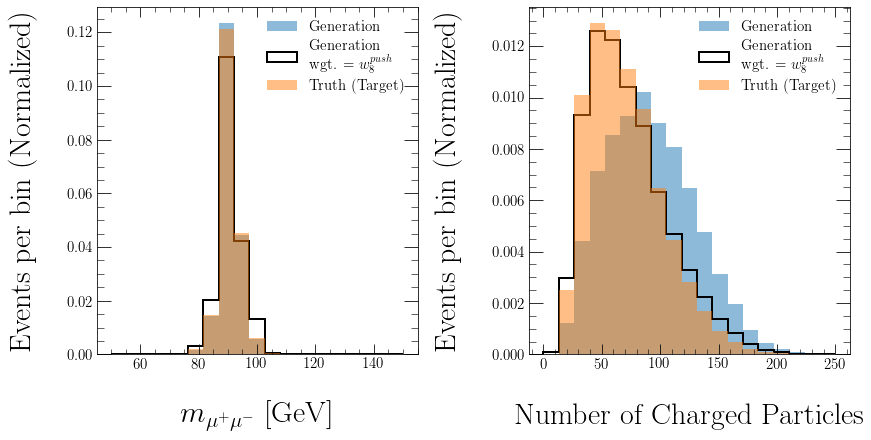

ITERATION: 9


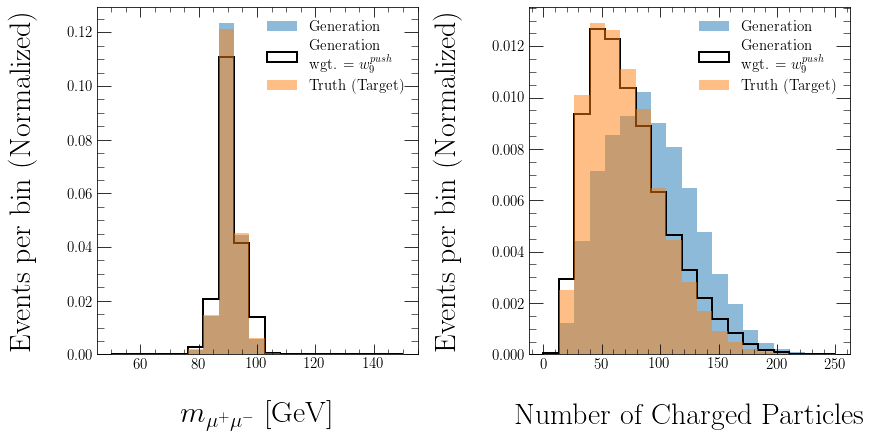

ITERATION: 10


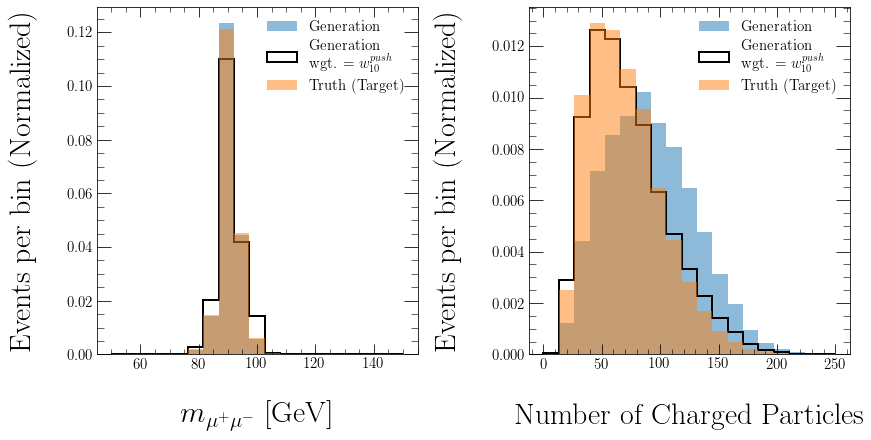

In [45]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(
        m_ll_0_G,
        #                weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)
    ax[0].hist(
        m_ll_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0].hist(
        m_ll_unknown_G,
        #                weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(
        nTracks_0_G,
        #                weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)
    ax[1].hist(
        nTracks_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1].hist(
        nTracks_unknown_G,
        #                weights=weightsMC_unknown[mypass_unknown],
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## OmniFold

Unfold the full phase space of the tracks.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [25]:
K.clear_session()

### Setup datasets

#### Get particle charge from particle ID

Since we can only observe charge at detector-level, we must convert the PID information at particle-level to charge information.

In [26]:
# Load different particles in dataset

truth_pdgId_Tracks_0 = Events_0.events['truth_pdgId_Tracks'][mypass_0]

truth_pdgId_Tracks_unknown = Events_unknown.events['truth_pdgId_Tracks'][mypass_unknown]

In [27]:
# See what kind of particles are in event

PIDs = []

for event in truth_pdgId_Tracks_0:
    for ID in event:
        if ID not in PIDs:
            PIDs += [ID]
            
for event in truth_pdgId_Tracks_unknown:
    for ID in event:
        if ID not in PIDs:
            PIDs += [ID]

In [28]:
PIDs

[-13,
 -211,
 321,
 211,
 -321,
 13,
 -2212,
 2212,
 -3312,
 3112,
 -11,
 11,
 -3222,
 3334,
 -3112,
 3312,
 3222,
 -3334]

In [29]:
# Look up particles and their charge from
# https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf

PID_to_charge = {
    11: -1,  # e^-
    13: -1,  # mu^-
    211: 1,  # pi^+
    321: 1,  # K^+
    2212: 1,  # p
    3112: -1,  # Sigma^-
    3312: -1,  # Xi^-
    3222: +1,  # Sigma^+
    3334: -1   # Omega^-
}  

In [30]:
def get_charge(pdgID):
    charges = awkward.array.jagged.JaggedArray.copy(pdgID)
    for i in range(len(charges)):
        for j in range(len(charges[i])):
            PID = charges[i][j]
            # anti-particles have a negative sign
            sign = PID / abs(PID)
            try:
                charge = sign * PID_to_charge[abs(PID)]
            except KeyError:
                raise ValueError(
                    "Unknown PID encountered: {}. Please add PID and corresponding charge to 'PID_to_charge.'"
                    .format(PID))
                return
            charges[i][j] = charge
    return charges

#### Load and process tracks

Unfolding the full phase space involves the use of EnergyFlow PFNs, which take zero-padded arrays as input.

In [31]:
truth_pT_Tracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
pT_Tracks_0 = Events_0.events['pT_Tracks'][mypass_0]

truth_eta_Tracks_0 = Events_0.events['truth_eta_Tracks'][mypass_0]
eta_Tracks_0 = Events_0.events['eta_Tracks'][mypass_0]

truth_phi_Tracks_0 = Events_0.events['truth_phi_Tracks'][mypass_0]
phi_Tracks_0 = Events_0.events['phi_Tracks'][mypass_0]

truth_charge_Tracks_0 = get_charge(truth_pdgId_Tracks_0)
charge_Tracks_0 = Events_0.events['charge_Tracks'][mypass_0]


truth_pT_Tracks_unknown = Events_unknown.events['truth_pT_Tracks'][mypass_unknown]
pT_Tracks_unknown = Events_unknown.events['pT_Tracks'][mypass_unknown]

truth_eta_Tracks_unknown = Events_unknown.events['truth_eta_Tracks'][mypass_unknown]
eta_Tracks_unknown = Events_unknown.events['eta_Tracks'][mypass_unknown]

truth_phi_Tracks_unknown = Events_unknown.events['truth_phi_Tracks'][mypass_unknown]
phi_Tracks_unknown = Events_unknown.events['phi_Tracks'][mypass_unknown]

truth_charge_Tracks_unknown = get_charge(truth_pdgId_Tracks_unknown)
charge_Tracks_unknown = Events_unknown.events['charge_Tracks'][mypass_unknown]

In [32]:
sum_pT_Tracks_0_G = [
    np.sum(truth_pT_Tracks_0[i]) for i in range(len(truth_pT_Tracks_0))
]
sum_pT_Tracks_0_S = [np.sum(pT_Tracks_0[i]) for i in range(len(pT_Tracks_0))]


sum_pT_Tracks_unknown_G = [
    np.sum(truth_pT_Tracks_unknown[i]) for i in range(len(truth_pT_Tracks_unknown))
]
sum_pT_Tracks_unknown_S = [np.sum(pT_Tracks_unknown[i]) for i in range(len(pT_Tracks_unknown))]

In [33]:
def get_max_dim(array):
    max_dim = max([len(array[i]) for i in range(len(array))])

    return max_dim

In [34]:
# normalize or standardize pT and center (y, phi)
def normalize_event(x, normalize=True):
    if normalize:
        yphi_avg = np.average(x[:, 1:3], weights=x[:, 0], axis=0)
        x[:, 1:3] -= yphi_avg
        x[:, 0] /= x[:, 0].sum()
    else:  # standardize
        x[:, 0] /= 100.
    return x

In [35]:
def preprocess_data(pT, eta, phi, charge, max_num_particles=None):
    num_events = len(pT)
    if max_num_particles == None:
        max_num_particles = get_max_dim(pT)

    result = np.empty(shape=(num_events, max_num_particles, 4))

    for i in range(num_events):
        pad_length = max_num_particles - len(pT[i])
        pad = np.zeros(shape=(pad_length, 4))

        event = np.stack((pT[i], eta[i], phi[i], charge[i]), axis=1)
        event = normalize_event(event, normalize=True)

        result[i] = np.concatenate((event, pad))

    return result

In [36]:
max_num_particles_G = max(get_max_dim(truth_pT_Tracks_0), get_max_dim(truth_pT_Tracks_unknown))
max_num_particles_S = max(get_max_dim(pT_Tracks_0), get_max_dim(pT_Tracks_unknown))

In [37]:
Tracks_0_G = preprocess_data(truth_pT_Tracks_0, truth_eta_Tracks_0,
                             truth_phi_Tracks_0, truth_charge_Tracks_0, max_num_particles_G)
Tracks_0_S = preprocess_data(pT_Tracks_0, eta_Tracks_0, phi_Tracks_0,
                             charge_Tracks_0, max_num_particles_S)

Tracks_unknown_G = preprocess_data(truth_pT_Tracks_unknown,
                                   truth_eta_Tracks_unknown,
                                   truth_phi_Tracks_unknown,
                                   truth_charge_Tracks_unknown, max_num_particles_G)
Tracks_unknown_S = preprocess_data(pT_Tracks_unknown, eta_Tracks_unknown,
                                   phi_Tracks_unknown, charge_Tracks_unknown, max_num_particles_S)

#### Construct observables

To verify fidelity of unfolding.

In [38]:
def get_nTracks(Tracks):
    result = []

    for i in range(len(Tracks)):
        mask = Tracks[i, :, 0] > 0
        nTracks = np.sum(mask)
        result += [nTracks]

    return np.array(result)

In [39]:
nTracks_0_G = get_nTracks(Tracks_0_G)
nTracks_unknown_G = get_nTracks(Tracks_unknown_G)
nTracks_0_S = get_nTracks(Tracks_0_S)
nTracks_unknown_S = get_nTracks(Tracks_unknown_S)

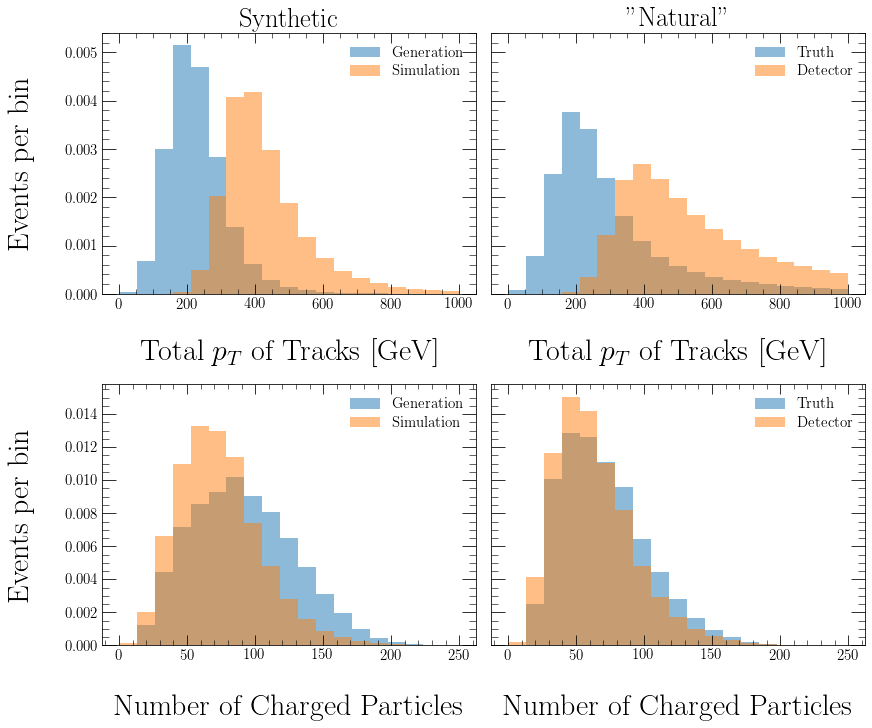

In [40]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(0, 1000, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('Total $p_T$ of Tracks [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('Total $p_T$ of Tracks [GeV]')
hG1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector', 
                          **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation', 
                          **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth', 
                          **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector', 
                          **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define OmniFold Algorithm

In [41]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta_0_G: synthetic simulation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level  events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def omnifold(iterations,
             theta_0_G,
             theta_0_S,
             theta_unknown_S,
             weightsMC_0=None,
             weightsMC_unknown=None):

    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G))

    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

    print("Jumpstarting Model\n")
    count = 0
    while count < 20:
        count += 1

        X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(
            xvals_1, yvals_1)

        model.model.compile(loss='binary_crossentropy',
                            optimizer=keras.optimizers.Adam(),
                            metrics=['accuracy'])
        history = model.fit(X_train_1,
                            Y_train_1,
                            epochs=1,
                            batch_size=10000,
                            validation_data=(X_test_1, Y_test_1),
                            verbose=1)
        if (history.history['val_loss'][0] < history.history['loss'][0] - 0.1
            ) or history.history['val_loss'][0] < 1:
            break
        else:
            del model
            K.clear_session()

            model = PFN(input_dim=4,
                        Phi_sizes=Phi_sizes,
                        F_sizes=F_sizes,
                        latent_dropout=0.2,
                        F_dropouts=0.2,
                        output_dim=1,
                        output_act='sigmoid',
                        summary=False)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., initial MC for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #         print("Jumpstarting Model\n")
        #         count = 0
        #         while count < 20:
        #             count += 1

        #             model.model.compile(loss='binary_crossentropy',
        #                                 optimizer=keras.optimizers.Adam(),
        #                                 metrics=['accuracy'])
        #             history = model.fit(X_train_1,
        #                                 Y_train_1,
        #                                 sample_weight=w_train_1,
        #                                 epochs=1,
        #                                 batch_size=10000,
        #                                 validation_data=(X_test_1, Y_test_1, w_test_1),
        #                                 verbose=1)
        #             if (history.history['val_loss'][0] < history.history['loss'][0]) or history.history['val_loss'][0]<1:
        #                 break
        #             else:
        #                 reset_weights(model.model)

        #         print("Training Model\n")
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # initial MC for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.model.compile(loss='binary_crossentropy',
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold the Full Phase Space

In [42]:
weights, _ = omnifold(iterations=5,
                      theta_0_G=Tracks_0_G,
                      theta_0_S=Tracks_0_S,
#                       weightsMC_0=weightsMC_0[mypass_0],
                      theta_unknown_S=Tracks_unknown_S)#,
#                       weightsMC_unknown=weightsMC_unknown[mypass_unknown])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Jumpstarting Model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1143892 samples, validate on 381298 samples
Epoch 1/1





1143892/1143892 [==============================] - 563s 492us/step - loss: 6.5200 - acc: 0.5902 - val_loss: 6.5104 - val_acc: 0.5916
Train on 1143892 samples, validate on 381298 samples
Epoch 1/1
1143892/1143892 [==============================] - 591s 517us/step - loss: 2.1684 - acc: 0.5685 - val_loss: 0.6760 - val_acc: 0.5923

ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 603s 527us/step - loss: 0.6766 - acc: 0.5917 - val_loss: 0.6761 - val_acc: 0.5919
Epoch 2/200
1143892/1143892 [==============================] - 602s 526us/step - loss: 0.6759 - acc: 0.5919 - val_loss: 0.6746 - val_acc: 0.5919
E

1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4016 - acc: 0.6685 - val_loss: 0.4322 - val_acc: 0.7175
Epoch 4/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4008 - acc: 0.6689 - val_loss: 0.4189 - val_acc: 0.7141
Epoch 5/200
1143892/1143892 [==============================] - 664s 581us/step - loss: 0.3999 - acc: 0.6700 - val_loss: 0.4263 - val_acc: 0.7141
Epoch 6/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.3990 - acc: 0.6708 - val_loss: 0.4316 - val_acc: 0.7205
Epoch 7/200
1143892/1143892 [==============================] - 666s 582us/step - loss: 0.3984 - acc: 0.6714 - val_loss: 0.4311 - val_acc: 0.7238
Epoch 8/200
1143892/1143892 [==============================] - 665s 582us/step - loss: 0.3980 - acc: 0.6721 - val_loss: 0.4282 - val_acc: 0.7208
Epoch 9/200
1143892/1143892 [==============================] - 665s 582us/step - loss: 0.3979 - acc: 0.6708 - val_loss: 0.4200 - val_acc: 0.71

1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4882 - acc: 0.6881 - val_loss: 0.5044 - val_acc: 0.7189
Epoch 3/200
1143892/1143892 [==============================] - 665s 582us/step - loss: 0.4871 - acc: 0.6885 - val_loss: 0.5068 - val_acc: 0.7113
Epoch 4/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4865 - acc: 0.6887 - val_loss: 0.5021 - val_acc: 0.7149
Epoch 5/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4857 - acc: 0.6889 - val_loss: 0.4988 - val_acc: 0.7137
Epoch 6/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4851 - acc: 0.6903 - val_loss: 0.4983 - val_acc: 0.7150
Epoch 7/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4846 - acc: 0.6900 - val_loss: 0.4989 - val_acc: 0.7198
Epoch 8/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.4848 - acc: 0.6898 - val_loss: 0.5069 - val_acc: 0.72

#### Step 1 Results (Simulation-level)

ITERATION: 1


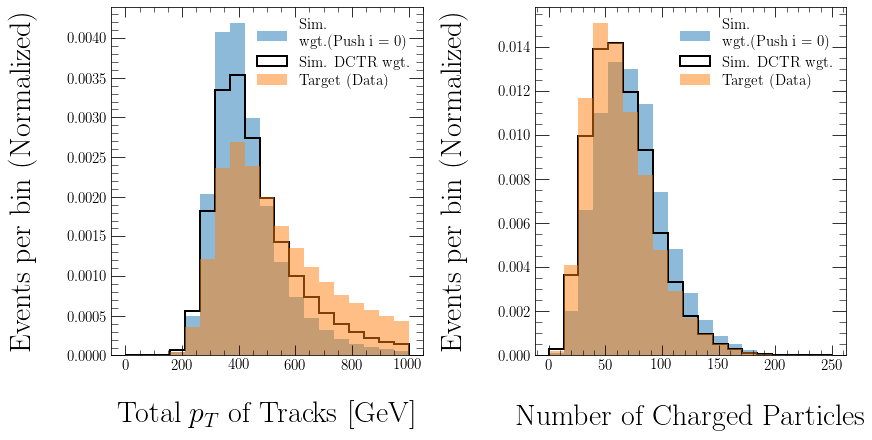

ITERATION: 2


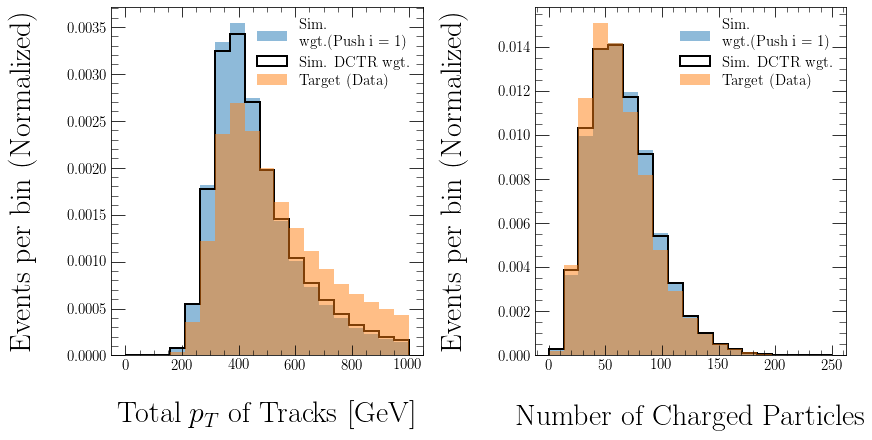

ITERATION: 3


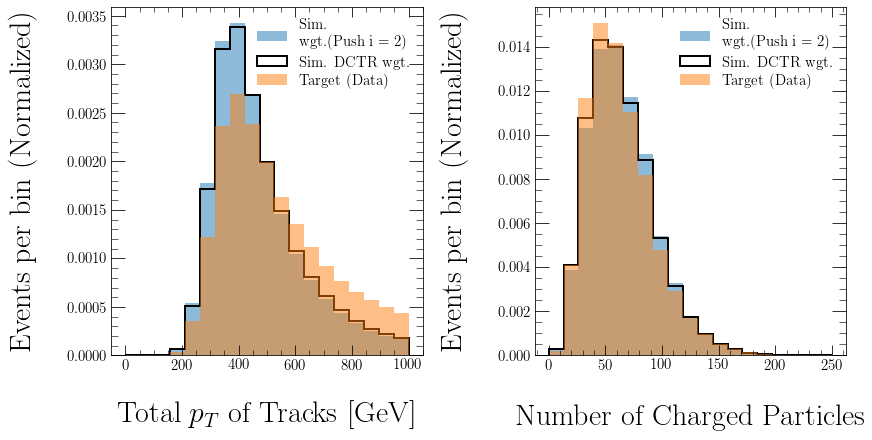

ITERATION: 4


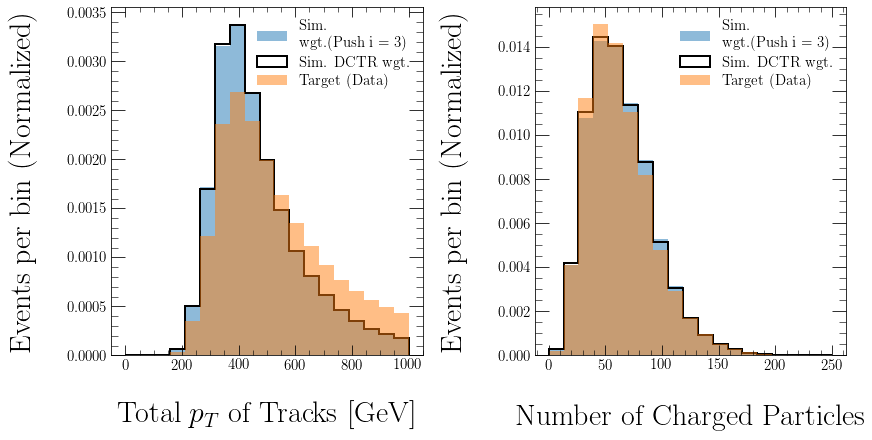

ITERATION: 5


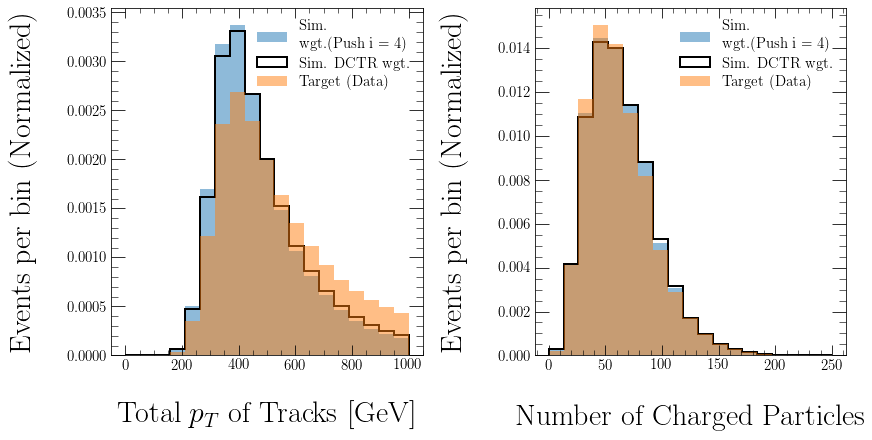

In [62]:
for i in range(len(weights)):
    print("ITERATION: {}".format(i + 1))
    
    if i == 0:
#         weights_init = weightsMC_0[mypass_0]
        weights_init = np.ones(np.sum(mypass_0))

    else:
        weights_init = weights[i - 1, 0, :]
        
    bins = np.linspace(0, 1000, 20)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax[0].set_xlabel('Total $p_T$ of Tracks [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(sum_pT_Tracks_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
               **plot_style_2)
    ax[0].hist(sum_pT_Tracks_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
               **plot_style_1)

    ax[0].hist(sum_pT_Tracks_unknown_S,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Data (Target)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
               **plot_style_2)
    ax[1].hist(nTracks_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
               **plot_style_1)
    ax[1].hist(nTracks_unknown_S,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Data (Target)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION: 1


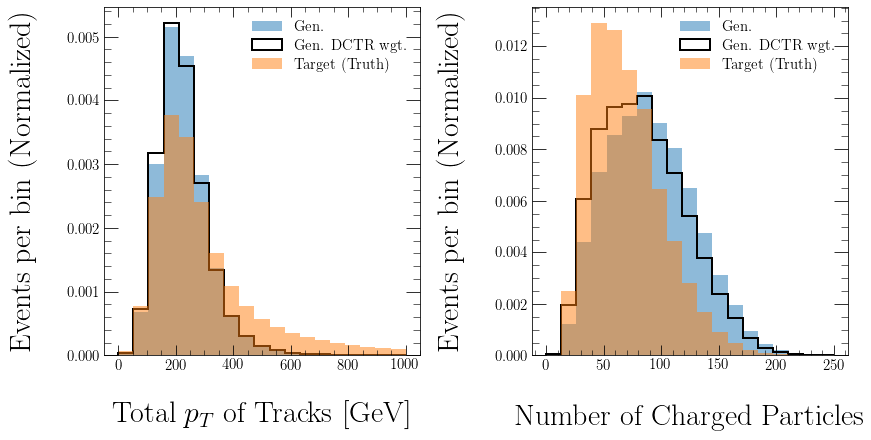

ITERATION: 2


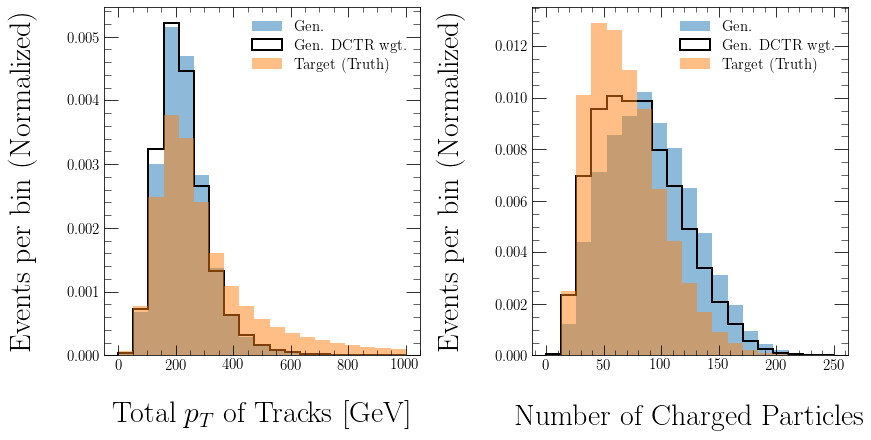

ITERATION: 3


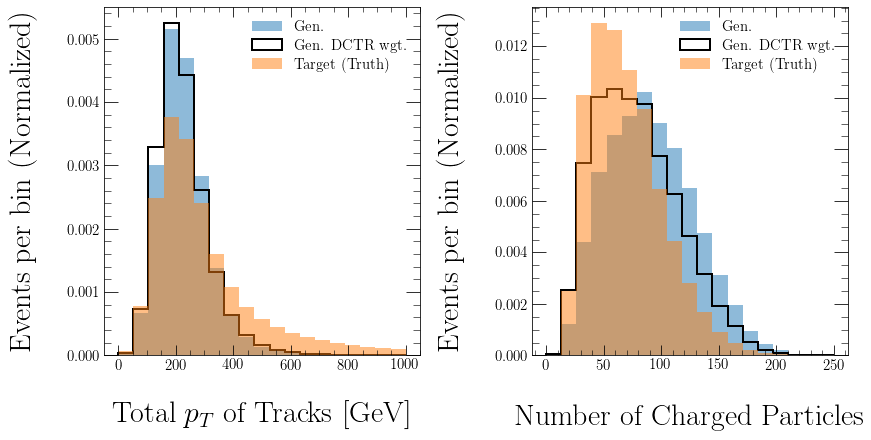

ITERATION: 4


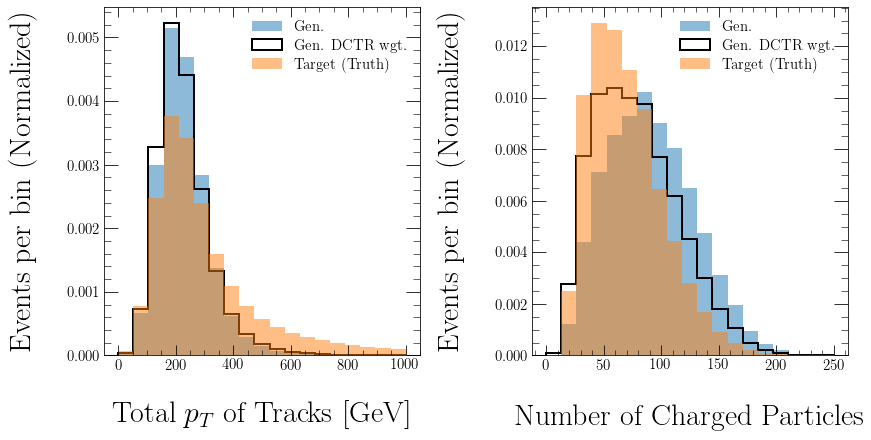

ITERATION: 5


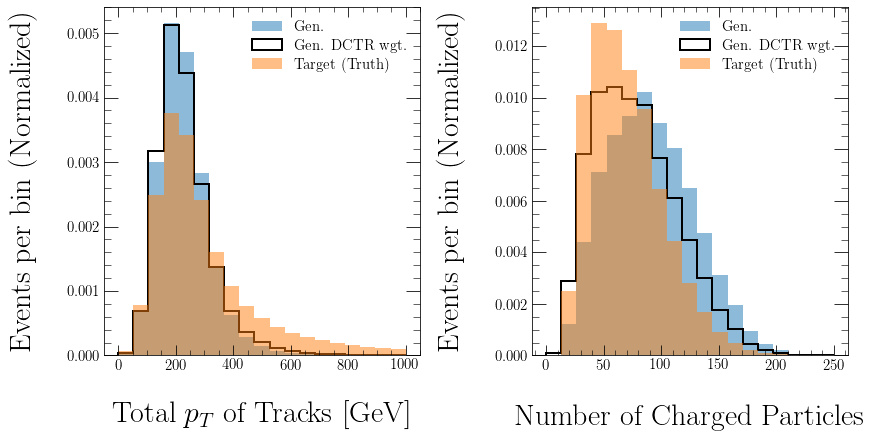

In [43]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0, 1000, 20)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax[0].set_xlabel('Total $p_T$ of Tracks [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(sum_pT_Tracks_0_G,
#                weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Generation',
               **plot_style_2)
    ax[0].hist(sum_pT_Tracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
               **plot_style_1)

    ax[0].hist(sum_pT_Tracks_unknown_G,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Truth (Target)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G,
#                weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Generation',
               **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Truth (Target)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()